In [ ]:
!gdown 1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
!gdown 13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
!gdown 1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
!gdown 1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
!unzip -q data

Downloading...
From (original): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
From (redirected): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG&confirm=t&uuid=ad38445f-a870-4d86-9684-d5bc5783c9c4
To: /content/data.zip
100% 960M/960M [00:07<00:00, 134MB/s] 
Downloading...
From: https://drive.google.com/uc?id=13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
To: /content/merged.json
100% 2.58M/2.58M [00:00<00:00, 23.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
To: /content/val.json
100% 144k/144k [00:00<00:00, 12.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
To: /content/faulty.csv
100% 25.8k/25.8k [00:00<00:00, 47.1MB/s]


In [ ]:
!pip -q install transformers openai-clip wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import trange
import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import ImageFile
import random
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import pandas as pd
import os
import math

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# WanB login - Make sure to change the login call to wandb.login(key='<yourapikey>') the first time you run.
wandb.login(key='<yourapikey>')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
      project="mlrc",
      name=f"norm_again",
      config={"learning_rate": 5e-6,"epochs": 10,})

wandb: Currently logged in as: harshvardhanmestha. Use `wandb login --relogin` to force relogin


In [ ]:
##options for model
ckpt_pth = '' # path to a checkpoint file
en_scheduler = False #enable scheduler
en_balanced_lambda = False #enable lambda balancing as decscribed in Section X.X of our paper
lambda_mode = 'modal' # can be one of ['norm','modal','log']
en_countplus = False
en_data_check = False #iterate over the dataloader once to check if there are any faulty images present (for other datasets)
fix_faulty = True #Required to be true for our dataset

In [ ]:
#paths for the images and their respective data
json_path = '/content/merged.json'
image_path = '/content/data/merged'
val_image_path = '/content/data/VAL'
val_json_path = '/content/val.json'
faulty_path = '/content/faulty.csv'

In [ ]:
# Loading and fixing raw training data
with open(json_path, 'r') as f:
    input_data = []
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)

if fix_faulty:
  faulty = pd.read_csv(faulty_path)
  indexes = list(faulty["index"])
  json_strs = list(faulty["json_str"])

  for i in trange(len(indexes)):
    input_data[int(indexes[i])] = json.loads(json_strs[i])


100%|██████████| 100/100 [00:00<00:00, 60116.15it/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 104MiB/s]


In [ ]:
# class for the dataset, handles image preprocessing and text tokenization
class image_title_dataset():
    def __init__(self, list_image_path,list_txt,list_txt_cf):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)
        self.cf_title = clip.tokenize(list_txt_cf)
        self.raw_txts = list_txt
        self.raw_counts = list_counts

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        cf_title = self.cf_title[idx]
        raw_txts = self.raw_txts[idx]
        raw_counts = self.raw_counts[idx]
        return image, title, cf_title, raw_txts, raw_counts

In [ ]:
num2word = {1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
               6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten'}

In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

def count_loss(ei,ek,ek_cf,countplus=False):
    loss = 0
    if countplus==False:
      # Normalize embeddings
      ei = torch.squeeze(ei).to(torch.float64)/ei.norm(dim=1)
      ek = torch.squeeze(ek).to(torch.float64)/ek.norm(dim=1)
      ek_cf = torch.squeeze(ek_cf).to(torch.float64)/ek_cf.norm(dim=1)

      # Calculate loss
      loss = -torch.log(torch.exp(torch.dot(ei,ek))/(torch.exp(torch.dot(ei,ek))+torch.exp(torch.dot(ei,ek_cf))))
      return loss
    else:
      # print(ek.shape)

      ei = torch.squeeze(ei).to(torch.float64)/ei.norm(dim=1)
      ek = torch.squeeze(ek).to(torch.float64)/ek.norm(dim=1)
      deno_e = []
      num = torch.exp(torch.dot(ei,ek))
      deno = 0
      # print(ek_cf.shape)
      # print(ek_cf[0].shape)
      # print(ek.shape)

      for i in range(9):
        e = torch.unsqueeze(ek_cf[i], 0)
        deno_e.append(torch.squeeze(e).to(torch.float64)/e.norm(dim=1))
      for i in range(len(deno_e)):
        deno = deno + torch.exp(torch.dot(ei,deno_e[i]))

      loss = -torch.log(num/deno)
      return loss


    return loss

In [ ]:
def generate_caps(cap,count,counterfactual=False):
  '''
  generate_caps() - Function to generate captions by replacing the number in the current caption. Only for counting images.

  inputs:
    - cap:str = The caption of the image
    - count:int = The count of the image
    - counterfactual:bool = If true a random number is chosen for replacing the current number otherwise produces all possible valid combinations.

  outputs:
    - val_caps:str or list() of str = List containing all combinations of the caption, or str containing caption with count replaced with a random number,
      depending on value of counterfactual.
  '''

  val_caps = []
  if counterfactual==False:
    for c in list(set(range(1,11)) - set([1])):
      val_cap = cap.replace(num2word[count],num2word[c])
      val_caps.append(val_cap)

  if counterfactual==True:
    l = list(set(range(1,11)) - set([1,count]))
    n = random.choice(l)
    val_caps = cap.replace(num2word[count],num2word[n])

  return val_caps

In [ ]:
## Variables for logging
list_image_path = []
list_txt = []
list_txt_cf = []
list_counts = []


## Initalising the Dataloader for the training data
for item in input_data:
  img_path = image_path +str('/')+ item['pths'].split('/')[-1]
  caption = item['caps'][:110]
  # caption = item['caps']
  counts = item['counts']


  if counts>0:
    cf_cap = generate_caps(caption.lower(),counts,counterfactual=True)
    list_txt_cf.extend([cf_cap] * 5)

  list_image_path.append(img_path)
  list_txt.append(caption)
  list_counts.append(counts)

dataset = image_title_dataset(list_image_path, list_txt, list_txt_cf)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=False) #Define your own dataloader

# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

if device == "cpu":
  model.double()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=5e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

if en_scheduler:
  linear = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1/3, total_iters=5)
  cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,last_epoch=10)
  scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linear,cosine], milestones=[5])

if en_data_check: #checking data
  pbar = tqdm(train_dataloader, total=len(train_dataloader))
  for batch in pbar:
    pass

# Loading from checkpoint (if enabled)
if len(ckpt_pth)>0:
  api = wandb.Api()
  run = api.run(ckpt_pth)

  run.file("model_9.pt").download()
  model_ckpt = torch.load('model_9.pt')
  model.load_state_dict(model_ckpt)

  run.file("optimizer_9.pt").download()
  optimizer_ckpt = torch.load('optimizer_9.pt')
  optimizer.load_state_dict(optimizer_ckpt)

  run.file("scheduler_9.pt").download()
  scheduler_ckpt = torch.load('scheduler_9.pt')
  scheduler.load_state_dict(scheduler_ckpt)

print("\nData and model ready.")




Data and model ready.


In [ ]:
def get_lambda(text,count):
  '''
  get_lambda() - Function implementing Lambda Balancing as described in Section X.X of our paper.
  Applies when en_lambda is set to True. Recommended to use for small, class-imbalanced training data.

  inputs:
    - text:str = caption of the (counting) image

  outputs:
    - lmbda:float = lambda corresponding to the given caption
  '''

  lmbda = 1
  l = list_counts
  n_count = len(train_dataloader)
  lmbda0 = 1

  if lambda_mode == 'norm':
    if num2word[count] in text and count == 2: lmbda = 1-(list_counts.count(2)/n_count)
    if num2word[count] in text and count == 3: lmbda = 1-(list_counts.count(3)/n_count)
    if num2word[count] in text and count == 4: lmbda = 1-(list_counts.count(4)/n_count)
    if num2word[count] in text and count == 5: lmbda = 1-(list_counts.count(5)/n_count)
    if num2word[count] in text and count == 6: lmbda = 1-(list_counts.count(6)/n_count)
    if num2word[count] in text and count == 7: lmbda = 1-(list_counts.count(7)/n_count)
    if num2word[count] in text and count == 8: lmbda = 1-(list_counts.count(8)/n_count)
    if num2word[count] in text and count == 9: lmbda = 1-(list_counts.count(9)/n_count)
    if num2word[count] in text and count == 10: lmbda = 1-(list_counts.count(10)/n_count)

  if lambda_mode == 'modal':
    if num2word[count] in text and count == 2: lmbda = (list_counts.count(2)/list_counts.count(2))
    if num2word[count] in text and count == 3: lmbda = (list_counts.count(2)/list_counts.count(3))
    if num2word[count] in text and count == 4: lmbda = (list_counts.count(2)/list_counts.count(4))
    if num2word[count] in text and count == 5: lmbda = (list_counts.count(2)/list_counts.count(5))
    if num2word[count] in text and count == 6: lmbda = (list_counts.count(2)/list_counts.count(6))
    if num2word[count] in text and count == 7: lmbda = (list_counts.count(2)/list_counts.count(7))
    if num2word[count] in text and count == 8: lmbda = (list_counts.count(2)/list_counts.count(8))
    if num2word[count] in text and count == 9: lmbda = (list_counts.count(2)/list_counts.count(9))
    if num2word[count] in text and count == 10: lmbda = (list_counts.count(2)/list_counts.count(10))

  if lambda_mode == 'log':
    sigma = []
    for i in range(2,11):
      sigma.append(math.log2(math.log2(n_count/list_counts.count(i))))

    smax = max(sigma)
    smin = min(sigma)

    if num2word[count] in text and count == 2: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 3: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 4: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 5: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 6: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 7: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 8: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 9: lmbda = ((sigma[count-2] - smin)/smax)+1
    if num2word[count] in text and count == 10: lmbda = ((sigma[count-2] - smin)/smax)+1


  return lmbda*lmbda0

In [ ]:
def get_preds(pth,model):
  '''
    get_preds() - Runs the validation loop, obtains predictions for the zero-shot classification task and reports validation metrics.

    inputs:
        - pth: Path to validation data
        - model:CLIPModel

    outputs:
        - y:[int] = Ground Truth
        - y_pred:[int] = Model Predictions
        - np.mean(all_val_loss):float = mean validation loss on the validation set
        - val_acc: Zero-Shot Classifiaction Accuracy
        - f1_scores: F1 Scores for each class
  '''
  #opening validation data
  with open(pth, 'r') as f:
      val_input_data = []
      for line in f:
          obj = json.loads(line)
          val_input_data.append(obj)

  all_sims = []
  c = 0
  all_val_loss = []
  y = []
  y_pred = []
  lbls = []
  lmbda = 1

  with torch.no_grad():
    for i in trange(len(val_input_data)):

      try:
        sims = []
        img = Image.open(val_input_data[i]['pths'])
        cap = val_input_data[i]['caps'].lower()
        cap = cap[0:77]
        count = val_input_data[i]['counts']

        # print(count)
        cf_cap = generate_caps(cap,count,counterfactual=True)
        val_caps = generate_caps(cap,count)

        img = preprocess(img).to(device)
        encoded_image = model.encode_image(torch.unsqueeze(img, 0))
        encoded_image = encoded_image.to(device)

        tokenized_f_text = clip.tokenize(cap).to(device)
        encoded_f_text = model.encode_text(tokenized_f_text)
        encoded_f_text = encoded_f_text.to(device)

        tokenized_cf_text = clip.tokenize(cf_cap).to(device)
        encoded_cf_text = model.encode_text(tokenized_cf_text)
        encoded_cf_text = encoded_cf_text.to(device)

        ei = encoded_image
        ek = encoded_f_text
        ek_cf = []
        if en_countplus==False:ek_cf = encoded_cf_text


        for j in range(9):
          tokenized_text = clip.tokenize(val_caps[j]).to(device)
          encoded_text = model.encode_text(tokenized_text)
          encoded_text = encoded_text.to(device)
          if en_countplus:
            ek_cf.append(torch.squeeze(encoded_text))
          similarity = torch.cosine_similarity(encoded_text, encoded_image)
          sims.append(float(similarity))
        # print(len(ek_cf))
        # print(ek_cf[0].shape)
        all_sims.append((sims,count))
        logits_per_image, logits_per_text = model(torch.unsqueeze(img,0), tokenized_f_text)

        ground_truth = torch.arange(len(torch.unsqueeze(img,0)),dtype=torch.long,device=device)

        if en_balanced_lambda:
          lmbda = get_lambda(cap,count)


        counting_loss = count_loss(ei,ek,ek_cf,en_countplus)
        val_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        all_val_loss.append(val_loss.item())

        # print(val_loss.item())
      except:
         c=c+1
         pass
    print(c)
  # return np.mean(all_val_loss),all_sims
  for i in range(len(all_sims)):
    y_pred.append(all_sims[i][0].index(max(all_sims[i][0]))+2)
    y.append(all_sims[i][1])

  val_acc = accuracy_score(y, y_pred)
  f1_scores = f1_score(y, y_pred, average=None)

  return y,y_pred,np.mean(all_val_loss),val_acc,f1_scores



In [ ]:
def store_cf(y,y_pred,epoch):
  '''
  store_cf() - Function saving unnormalised confusion matrix to wandb (if enabled) or locally

  inputs:
    - y:[int] = ground truth
    - y_pred:[int] = model predictions
    - epoch:int = current epoch

  outputs:
    - unnormalised confusion matrix as a pdf
  '''
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)

  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_{}.pdf"))
  except:
    plt.savefig("/content/cfmat.pdf")
    files.download("/content/cfmat.pdf")

  plt.show()



In [ ]:
def store_cf_norm(y,y_pred,epoch):
  '''
  store_cf_norm() - Function saving normalised confusion matrix to wandb (if enabled) or locally

  inputs:
    - y:[int] = ground truth
    - y_pred:[int] = model predictions
    - epoch:int = current epoch

  outputs:
    - normalised confusion matrix as a pdf
  '''
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred,normalize='true')
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)
  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_norm_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_norm_{}.pdf"))
  except:
    plt.savefig("/content/cfmat_norm.pdf")
    files.download("/content/cfmat_norm.pdf")

  plt.show()



Epoch 0/10, Loss: 0.7260:   3%|▎         | 58/2101 [00:17<08:32,  3.98it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:10<00:00,  7.62it/s]


31


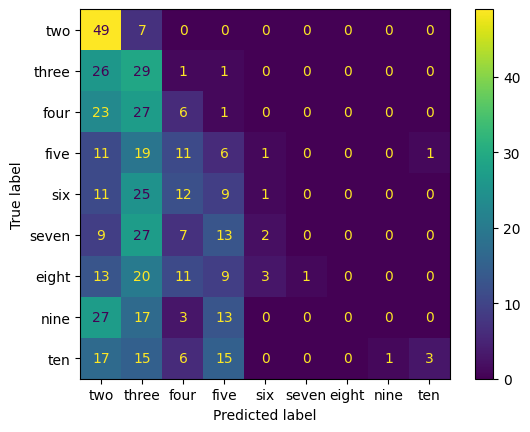

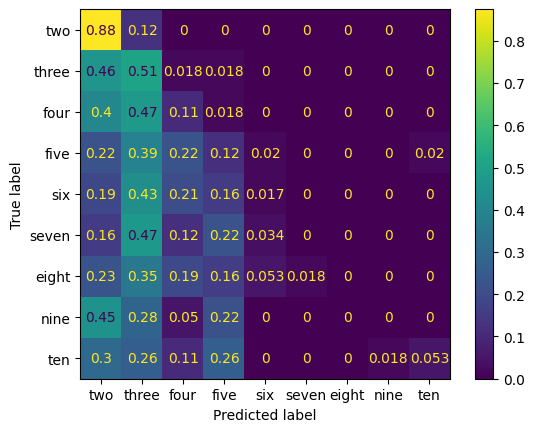

Validation Loss: 0.6727562675619083
Validation Accuracy: 0.18467583497053044


Epoch 1/10, Loss: 0.6907:   3%|▎         | 58/2101 [00:14<08:26,  4.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:11<00:00,  7.51it/s]


31


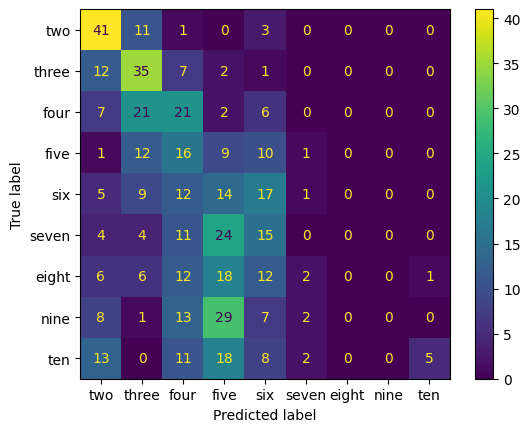

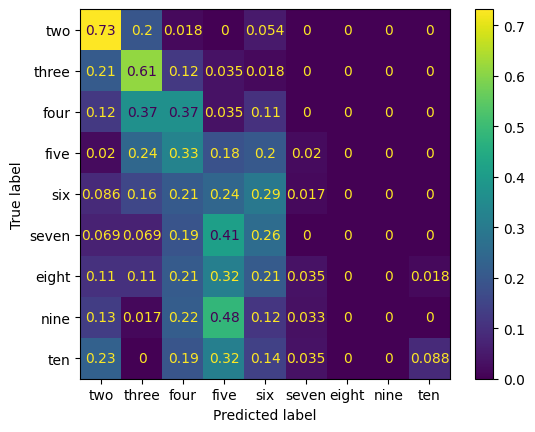

Validation Loss: 0.6560745389534244
Validation Accuracy: 0.25147347740667975


Epoch 2/10, Loss: 0.8712:   3%|▎         | 58/2101 [00:15<08:33,  3.98it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.42it/s]


31


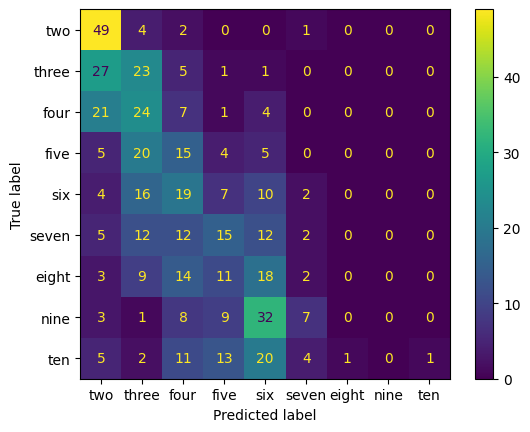

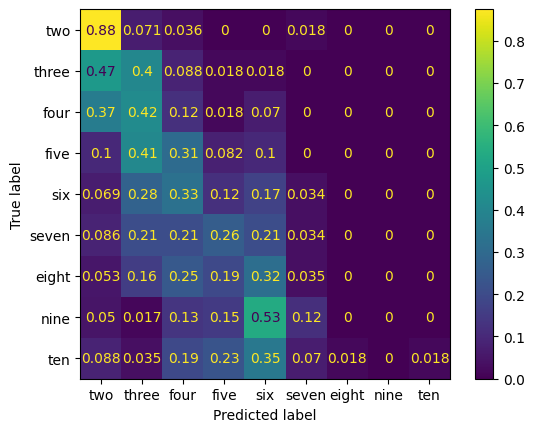

Validation Loss: 0.6600107598258863
Validation Accuracy: 0.18860510805500982


Epoch 3/10, Loss: 0.7596:   3%|▎         | 58/2101 [00:15<09:00,  3.78it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.36it/s]


31


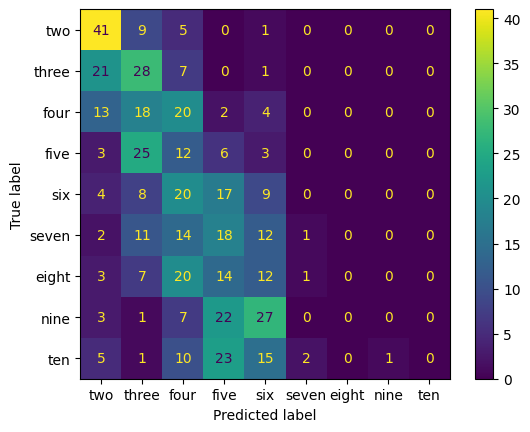

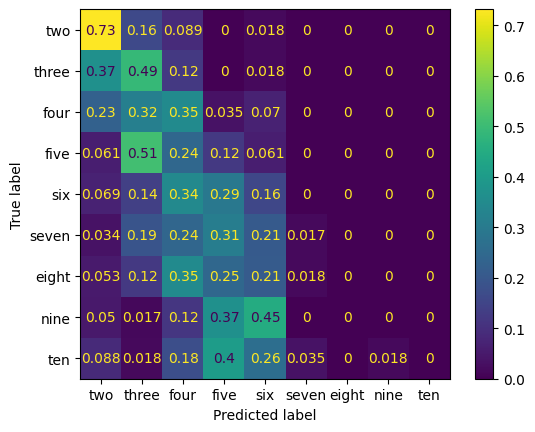

Validation Loss: 0.6591570378668071
Validation Accuracy: 0.206286836935167


Epoch 4/10, Loss: 0.7670:   3%|▎         | 58/2101 [00:15<08:45,  3.89it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.43it/s]


31


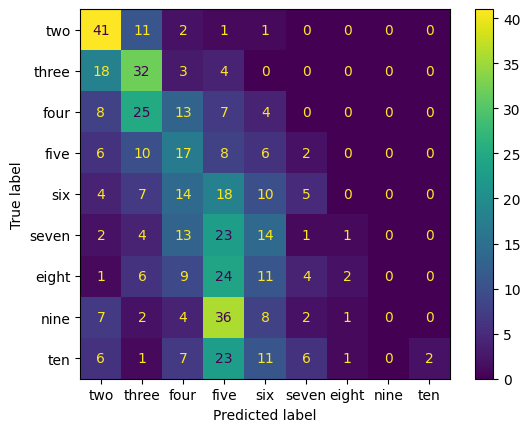

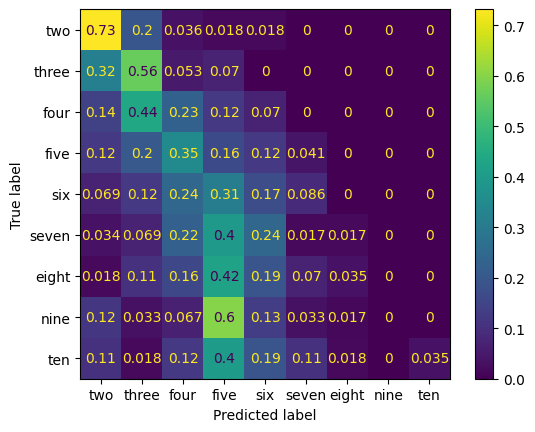

Validation Loss: 0.639721890411552
Validation Accuracy: 0.21414538310412573


Epoch 5/10, Loss: 0.6255:   3%|▎         | 58/2101 [00:15<08:28,  4.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.41it/s]


31


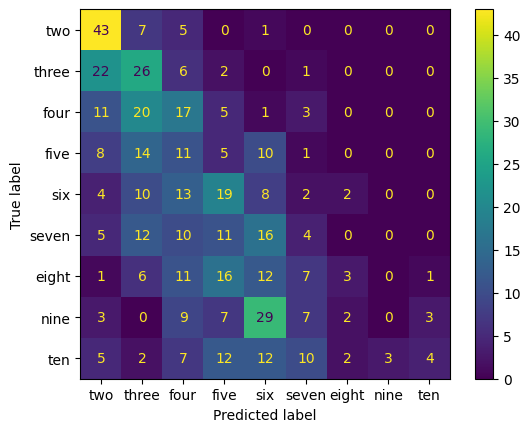

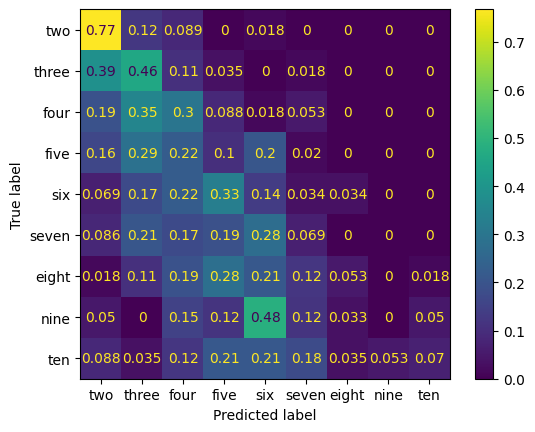

Validation Loss: 0.6518887550011191
Validation Accuracy: 0.21611001964636542


Epoch 6/10, Loss: 0.5892:   3%|▎         | 58/2101 [00:15<08:51,  3.84it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:15<00:00,  7.15it/s]


31


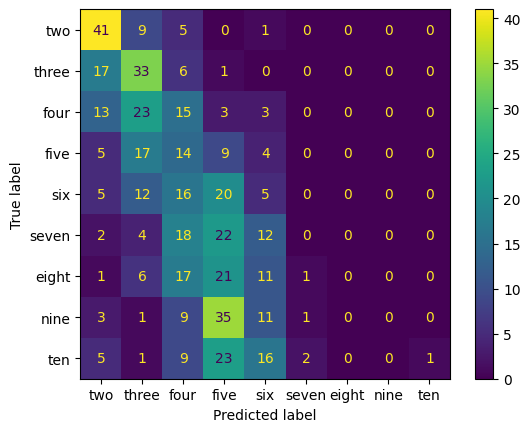

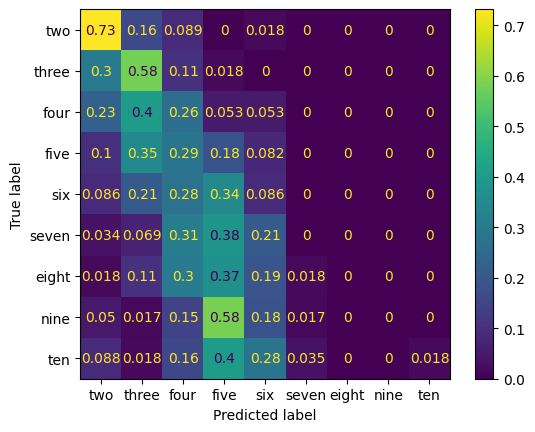

Validation Loss: 0.6516304539652942
Validation Accuracy: 0.2043222003929273


Epoch 7/10, Loss: 0.7511:   3%|▎         | 58/2101 [00:16<10:47,  3.15it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.35it/s]


31


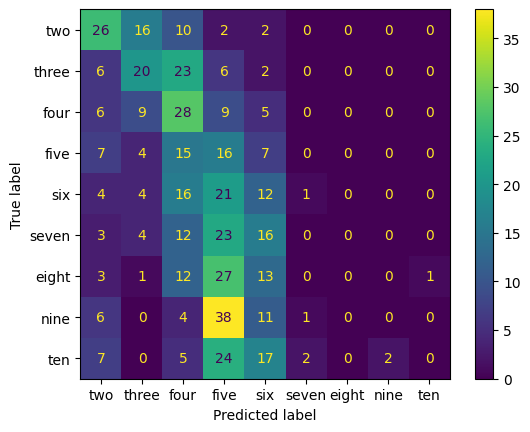

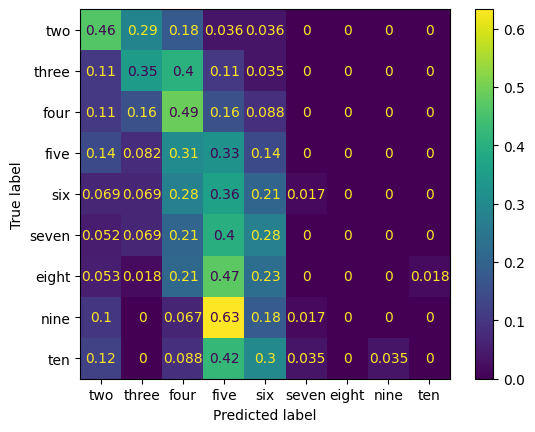

Validation Loss: 0.6519034889056541
Validation Accuracy: 0.20039292730844793


Epoch 8/10, Loss: 0.5975:   3%|▎         | 58/2101 [00:15<11:24,  2.98it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.32it/s]


31


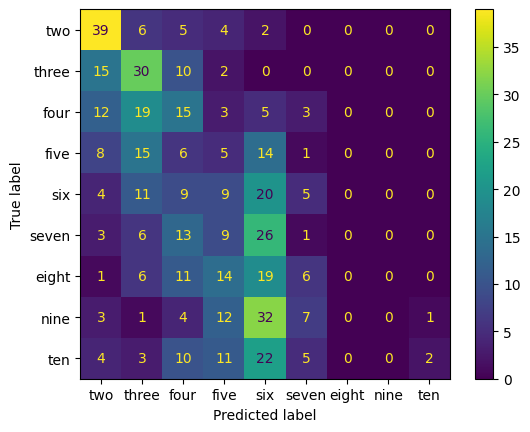

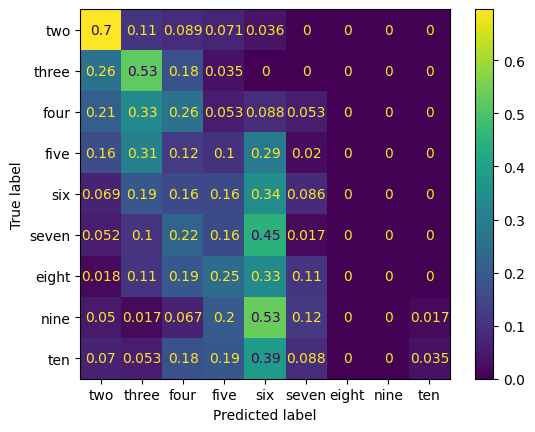

Validation Loss: 0.651181956538536
Validation Accuracy: 0.2200392927308448


Epoch 9/10, Loss: 0.5674:   3%|▎         | 58/2101 [00:15<09:48,  3.47it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:14<00:00,  7.29it/s]


31


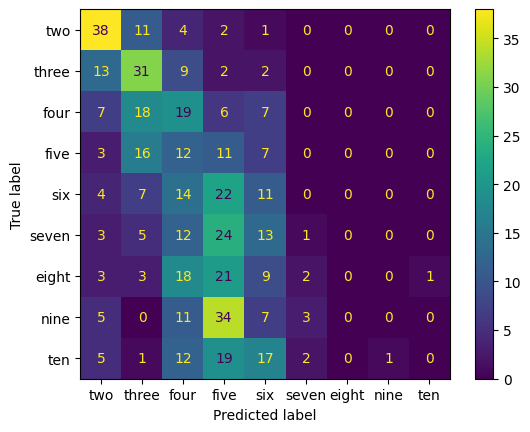

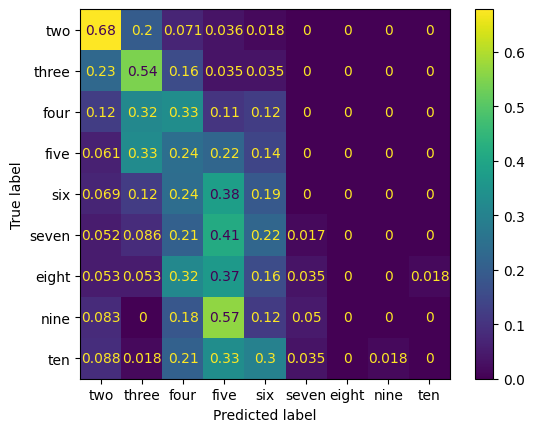

Validation Loss: 0.6474227092914068
Validation Accuracy: 0.2180746561886051
f1_score_class0: 0.5547445255474452
f1_score_class1: 0.4161073825503356
f1_score_class2: 0.2261904761904762
f1_score_class3: 0.11578947368421051
f1_score_class4: 0.16666666666666669
f1_score_class5: 0.0303030303030303
f1_score_class6: 0.0
f1_score_class7: 0.0
f1_score_class8: 0.0


In [ ]:
# Train the model
train_arr = []
val_arr = []
num_epochs = 10
lmbda = 1

for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss_arr = []
    val_loss_arr = []

    for batch in pbar:

        optimizer.zero_grad()
        images,texts,cf_texts,raw_txts,raw_counts = batch

        images = images.to(device)
        texts = texts.to(device)
        cf_texts = cf_texts.to(device)

        encoded_imgs = model.encode_image(images)
        encoded_texts = model.encode_text(texts)
        encoded_cf_texts = model.encode_text(torch.unsqueeze(cf_texts[4], 0))

        nc_enc_imgs = encoded_imgs[0:4]
        nc_enc_texts = encoded_texts[0:4]

        c_enc_imgs = encoded_imgs[4:]
        c_enc_texts = encoded_texts[4:]
        if en_countplus==False:
          ei = c_enc_imgs
          ek = c_enc_texts
          ek_cf = encoded_cf_texts
          counting_loss = count_loss(ei,ek,ek_cf)
        else:
          ei = c_enc_imgs
          ek = c_enc_texts
          val_caps = generate_caps(raw_txts[4].lower(),raw_counts[4].item())
          tokenized_text = clip.tokenize(val_caps).to(device)
          encoded_text = model.encode_text(tokenized_text)
          encoded_text = encoded_text.to(device)
          counting_loss = count_loss(ei,ek,encoded_text,en_countplus)


        # print(raw_txts[4])
        if en_balanced_lambda:
          lmbda = get_lambda(raw_txts[4].lower(),raw_counts[4].item())

        # print(lmbda)
        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        train_loss_arr.append(total_loss.item())
        # Backward pass

        total_loss.backward()
        if device == "cpu":
            optimizer.step()
            if en_scheduler:
              scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            if en_scheduler:
              scheduler.step()
            clip.model.convert_weights(model)

        wandb.log({"per_step_train_loss": total_loss.item()})
        wandb.log({"running_train_loss": sum(train_loss_arr)/len(train_loss_arr)})


        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {sum(train_loss_arr)/len(train_loss_arr):.4f}")

    y,y_pred,val_loss,val_acc,f1_scores = get_preds(val_json_path,model)
    val_loss_arr.append(val_loss)
    store_cf(y,y_pred,epoch)
    store_cf_norm(y,y_pred,epoch)

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")
    wandb.log({"per_epoch_val_loss": val_loss})
    wandb.log({"per_epoch_val_acc": val_acc})

    if (epoch+1) % 10 == 0:
      for i in range(len(f1_scores)):
        print(f"f1_score_class{i}: {f1_scores[i]}")
      torch.save(model.state_dict(), os.path.join(wandb.run.dir, f"model_{epoch}.pt"))
      torch.save(optimizer.state_dict(), os.path.join(wandb.run.dir, f"optimizer_{epoch}.pt"))
      if en_scheduler:
        torch.save(scheduler.state_dict(), os.path.join(wandb.run.dir, f"scheduler_{epoch}.pt"))


    wandb.log({"per_epoch_loss": np.mean(train_loss_arr)})
    train_arr.append(train_loss_arr)


In [ ]:
wandb.finish()

In [ ]:
from google.colab import runtime
runtime.unassign()